# Building a global vectors and word2vec model 

# Content

* Global Vectors for word representation
* Word to Vec for word representation
* TFIDF
* Neural Networks
* Sentiment Analysis

# Tools used

* Python
* SKlearn
* numpy 
* Pickle
* Gensim 
* Keras 
* Matplot lib
* Bokeh 


# In this project :

* I will use Global vectors for word representations

* Use word to vec for word representations

* Perform Sentiment analysis on word to vec using Naive Bayes

* Build a neural networks on word to vec model 

* compare the results of these models 

In [1]:
import pickle

# Third Party Libraries
import numpy as np
from scipy import sparse

%matplotlib inline 

# Word Embeddings vs Vector Space Models 

The main difference is how to get the term vectors, not the idea of a word/term being represented by a vector.

In inverted indexing, originally, you have a list of documents associated to a word (where the word appear), and if you use TF-IDF, that word will be associated with the TF-IDF values of its document list. Then the term vectors are used to calculate the similarity between two documents, or two textual units in general. The two term vectors can also be used to calculate the "relationship" between their corresponding words. But this relationship is not semantically or syntactically related, it's just about the level of common occurrence in the textual units to be learnt from. For example, the "similarity" of two words "neural" and "network" (computed by cosine distance) formed from inverted index of a deep learning corpus might be very large (almost 1), meaning they are very similar, but in fact, they are commonly occurred in this kind of corpus, not similar in meaning.


On the other hand, more advanced vector representations of term, such as word2vec or other distributed or distributional representation, are based on the distributional hypothesis (Harris, 1954): you can determine the meaning of a word by looking at its company (its context). If two words occur in a same "position" in two sentences, they are very much related either in semantics or syntactics.


For example, in a big text corpus, there are two sentences: "BMW is a German car manufacturer" and "BMW is a German automobile manufacturer". We, and the computer, can infer "car" and "automobile" are synonyms. Other two sentences: "We will go there this Thursday" and "I will go there this Sunday", Thursday and Sunday have the same syntactic role and they are somehow semantically related (days of the week).
word2vec are learnt (unsupervisedly) using neural network architecture (not really a neural network though), and term vectors are solely counted, not learnt. word2vec and the inverted indexing-based term vectors are not the only term vector representations, there are others: CCA, LSA, HAL, other distributed, neural-netword-based representations (as they are called word embeddings), etc..

# Global Vectors

The statistics of word occurrences in a corpus is the primary source of information available to all unsupervised methods for learning word representations, and although many such methods now exist, the question still remains as to how meaning is generated from these statistics, and how the resulting word vectors might represent that meaning.



The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, k.



Let P(k|w) be the probability that the word k appears in the context of word w. Consider a word strongly related to ice, but not to steam, such as solid. P(solid | ice) will be relatively high, and P(solid | steam) will be relatively low. Thus the ratio of P(solid | ice) / P(solid | steam) will be large. If we take a word such as gas that is related to steam but not to ice, the ratio of P(gas | ice) / P(gas | steam) will instead be small. For a word related to both ice and steam, such as water we expect the ratio to be close to one. We would also expect a ratio close to one for words related to neither ice nor steam, such as fashion.



The model generates two sets of word vectors. When the co-occurrence matrix is symmetric, these differ only as a result of their random initializations: the two sets of vectors should perform equivalently.




* We tokenize 

* build a vocabulary of the most frequent words,

* construct a matrix of co-occurence counts… 

* we use a decreasing weighting function so that word pairs that are d words apart contribute 1/d to the total count.



# Why Global Vectors 

Both models learn geometrical encodings (vectors) of words from their co-occurrence information (how frequently they appear together in large text corpora). 

They differ in that word2vec is a "predictive" model, whereas GloVe is a "count-based" model.

* In word2vec, Skipgram models tries to capture co-occurrence one window at a time

* In Glove it tries to capture the counts of overall statistics how often its appears.

So Glove model is less time and memory consuming, but they can scale with corpus size and capture more complex patterns beyond word similarity 

In [2]:
class GloVe(object):
    def __init__(self, corpus, window_size=3, vector_length=2):
        self.corpus = corpus
        self.window_size = window_size
        self.vec_length = vector_length
        # The bottom values are initialized after a corpus has been fed 
        self.token_size = 0
        self.word_to_index = None
        self.word_to_vec = None
        self.cache_matrix = None 
        # Due to the variable nature of text documents in relation to 
        # the number of words The value of cache matrix` will change 
        # after `cooccur_matrix()` is called. The result will be a 
        # matrix of size:
        #
        #          2*unique_word_count x (vector_length + 1)
        #
        # where the +1 is to account for the bias. The upper half of the
        # matrix will be assigned to the main word vectors, whereas the 
        # bottom half will be assigned to the context word vectors. 

    def vocabulary(self):
        vocab = self.corpus.split() 
        vocab = [element.lower() for element in vocab]
        tokens = list(set(vocab)) # Gets the unique words in the corpus
        token_size = len(tokens)

        word_to_index = {words: i for i, words in enumerate(tokens)}
        index_to_word = {index: word for word, index in word_to_index.items()}
        word_to_vec = {i: [np.random.uniform(-0.5, 0.5, size=self.vec_length), 
                           np.random.uniform(-0.5, 0.5, size=self.vec_length),
                           np.random.uniform(-0.5, 0.5, size=1),
                           np.random.uniform(-0.5, 0.5, size=1)]
                        for i, _ in enumerate(tokens)}

        setattr(self, 'token_size', token_size)
        setattr(self, 'word_to_index', word_to_index)
        setattr(self, 'word_to_vec', word_to_vec)
        setattr(self, 'cache_matrix', np.zeros((2*token_size, 
                                                self.vec_length+1)))

        return vocab

    def cooccur_matrix(self):
        vocab = self.vocabulary()

        cooccurrences = sparse.coo_matrix((self.token_size+1, self.token_size+1))

        # Creates a symmetric window around each word
        win = 2 * self.window_size + 1
        l = list(map(lambda x: self.word_to_index[x], vocab))
        lpadded = win // 2 * [self.token_size] + l + win // 2 * [self.token_size] 

        out = [lpadded[i:(i + win)] for i in range(len(l))]
        assert len(out) == len(l)

        d = []

        # Harmonically decaying weights
        for r in range(self.window_size):
            d.append(1/(r+1))

        d = np.array(d[::-1] + d)

        # Creates the cooccurrence matrix
        for windows in out:
            r = [windows[self.window_size] for i in range(win-1)]
            c = windows[:self.window_size] + windows[self.window_size+1:]

            sparse_temp = sparse.coo_matrix((d, (r, c)), 
                                            shape=(self.token_size+1, 
                                               self.token_size+1))
            cooccurrences += sparse_temp
            
        # Removes the padding row and column
        cooccurrences = sparse.coo_matrix(cooccurrences[:-1, :-1]) 

        return cooccurrences

    def train(self, epochs=4, x_max=3, alpha=0.75, learning_rate=0.0001, 
            decay_rate=0.9, annealing_rate=0.0, eps=0.00001):

        coocur_matrix= self.cooccur_matrix()

        values = coocur_matrix.data
        main_row = coocur_matrix.row
        context_row = coocur_matrix.col
        coocur_size = coocur_matrix.shape[0]

        del(coocur_matrix)

        for i in range(epochs):
            # Feedforward Pass
            vector_sums = np.zeros_like(getattr(self, 'cache_matrix'))
            total_cost=0

            for _, coord in enumerate(zip(main_row, context_row, values)):
                weight = (coord[-1]/x_max)**alpha if coord[-1] < x_max else 1
                main = coord[0]
                context = coord[1]

                inner_cost = np.dot(self.word_to_vec[main][0], 
                            self.word_to_vec[context][1])\
                            + self.word_to_vec[main][2]\
                            + self.word_to_vec[context][3]\
                            - np.log(coord[-1])

                total_cost += 0.5 * weight * inner_cost**2

                # Fills the vector_sums matrix with the sums in relation 
                # to the main and context word. `vector_sums` will then 
                # be used in the gradient to compute SGD. 
                vector_sums[main, :-1] += weight * inner_cost \
                                        * self.word_to_vec[context][1]
                vector_sums[context+self.token_size, :-1] += weight * inner_cost *\
                                                        self.word_to_vec[main][0]
                vector_sums[main, -1] += weight * inner_cost \
                                        * self.word_to_vec[context][3]
                vector_sums[context+self.token_size, -1] += weight * inner_cost\
                                                     * self.word_to_vec[main][2]

            eta = np.exp(-annealing_rate * i)

            # Backward Pass
            for i in range(self.token_size):
                # Main vector cache
                self.cache_matrix[i, :-1] = decay_rate\
                                          * self.cache_matrix[i, :-1]\
                                          + (1-decay_rate)\
                                          * vector_sums[i, :-1]**2
                # Context vector cache
                self.cache_matrix[i+self.token_size, :-1] = decay_rate \
                                              * self.cache_matrix[i+self.token_size, :-1] \
                                              + (1-decay_rate)\
                                              * vector_sums[i+self.token_size, :-1]**2
                # Main bias cache
                self.cache_matrix[i, -1] = decay_rate \
                                        * self.cache_matrix[i, -1] \
                                        + (1-decay_rate) \
                                        * vector_sums[i, -1]**2

                # Context bias cache
                self.cache_matrix[i+self.token_size, -1] = decay_rate\
                                                * self.cache_matrix[i+self.token_size, -1] \
                                                + (1-decay_rate)\
                                                * vector_sums[i+self.token_size, -1]**2

                # Updates the word vectors and biases
                # Main word vector
                self.word_to_vec[i][0] =- eta * learning_rate\
                                        * vector_sums[i, :-1]\
                                        / np.sqrt(self.cache_matrix[i, :-1]+eps)
                # Context word vector
                self.word_to_vec[i][1] =- eta * learning_rate\
                                        * vector_sums[i+self.token_size, :-1]\
                                        / np.sqrt(self.cache_matrix[i+self.token_size, :-1]+eps)
                # Main word bias
                self.word_to_vec[i][2] =- eta * learning_rate\
                                        * vector_sums[i, -1]\
                                        / np.sqrt(self.cache_matrix[i, -1]+eps)
                # Context word bias
                self.word_to_vec[i][3] =- eta * learning_rate\
                                        * vector_sums[i+self.token_size, -1]\
                                        / np.sqrt(self.cache_matrix[i+self.token_size, -1]+eps)

    def save(self, filename_labels, filename_vectors):
        """
        Saves the word labels to the file ``filename_labels`` and the
        word vectors (main, context, main-bias, and context-bias) to 
        ``filename_vectors``.
        """

        labels = self.word_to_index
        vectors = self.word_to_vec
        
        f_lab = open(filename_labels, "w")
        f_vec = open(filename_vectors, 'w')
        pickle.dump(labels, f_lab)
        pickle.dump(vectors, f_vec)
        f_lab.close()
        f_vec.close()

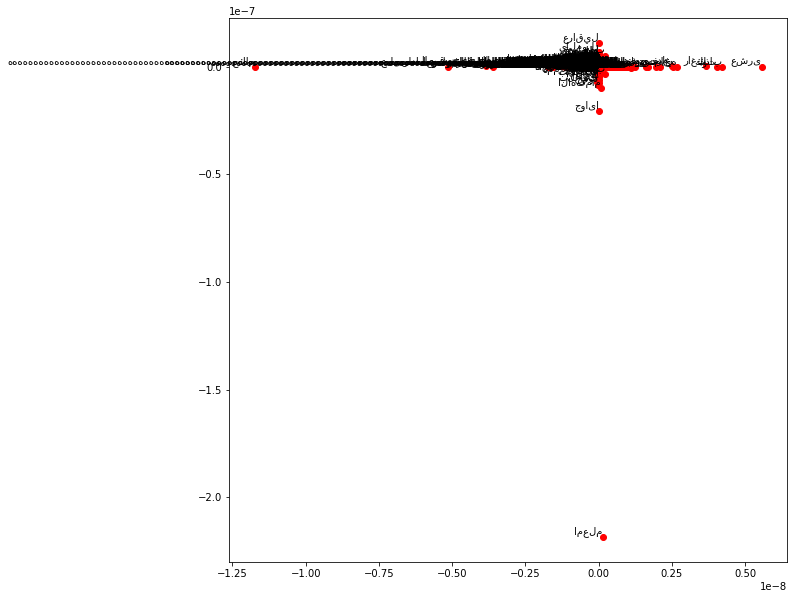

In [4]:
def main():
    import matplotlib.pyplot as plt

    file = 'train_out.txt'
    text = open(file, 'r', encoding='utf-8').read()
    temp = GloVe(text)
    temp.train()

    word_vec = temp.word_to_vec
    points = np.zeros((len(word_vec), 2))
    
    for i, _ in enumerate(word_vec):
        points[i] = np.mean([word_vec[i][0], word_vec[i][1]], axis=0)

    word_to_index = temp.word_to_index
    labels = [word for word, _ in word_to_index.items()]
    
    plt.figure(figsize=(10, 10))
    
    
    for label, x, y, in zip(labels, points[:, 0], points[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(-0, 0),
                     textcoords='offset points', ha='right', va='bottom')

    plt.plot(*zip(*points), marker='o', color='r', ls='')
    plt.show()

if __name__ == '__main__':
    # pass
    main()

# Word to vec representation

Now I will use word to vec(skip gram model) to represent words and perform sentiment analysis on them 

word2vec is that word vectors that are close to each other in the vector space represent words that are not only of the same meaning but of the same context as well.

What I find interesting about the vector representation of words is that it automatically embeds several features that we would normally have to handcraft ourselves. 

Since word2vec relies on Deep Neural Nets to detect patterns, we can rely on it to detect multiple features on different levels of abstractions.

In [5]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
filename = 'training_data_out.txt'

def parse_my_file(filename):
    with open(filename, encoding='utf-8') as f:
        for line in f:
            yield line.strip().split(' ',2)
            

            

In [10]:
df = pd.DataFrame(parse_my_file(filename))
df.columns = ['id','sent', 'tweet']

In [11]:
df = df.drop(df.index[0])

In [12]:
df_train = df

In [13]:
def ingest():
    data = df_train
    data.drop(['id'], axis=1, inplace=True)
    data.drop_duplicates()
    #data.reset_index(inplace=True)
    print('dataset loaded with shape', data.shape)
    return data

In [14]:
data = ingest()
#data.drop('level_0', axis = 1)
data.head(5)

dataset loaded with shape (6064, 2)


,sent,tweet
1,negative,فينو اهبل ابن اهبل
2,positive,على مصرييي جمال رب يحمي لينك
3,positive,منشن دوله كتير اوى دم خفيف عماره الله انا فيها...
4,negative,انا بعد كده خلى لى يوعنى حاجه همضى على وصل اما...
5,negative,انا هنتحر


tokenizin

In [15]:
def tokenize(tweet):
    try:
        tweet = unicode(tweet.decode('utf-8').lower())
        tokens = tokenizer.tokenize(tweet)
        #tokens = filter(lambda t:  t.startswith('@'), tokens)
        #tokens = filter(lambda t:  t.startswith('#'), tokens)
        #tokens = filter(lambda t:  t.startswith('http'), tokens)
        return tokens
    
    except:
        return 'NC'

In [16]:
tokenize(str(df_train.tweet))

'NC'

In [17]:
def postprocess(data, n=1000000):
    data = data.head(n)
    data['tokens'] = data['tweet'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    #data.drop('level_0', inplace=True)
    return data

data = postprocess(data)

progress-bar: 100%|██████████| 6064/6064 [00:00<00:00, 286428.29it/s]


In [18]:
x_train, x_test, y_train, y_test = train_test_split(df_train.tweet.values.astype('U'), df_train.sent.values.astype('U'), test_size=0.25)



Before feeding lists of tokens into the word2vec model, we must turn them into LabeledSentence objects beforehand. Here's how to do it:


In [19]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

4548it [00:00, 99969.05it/s]
1516it [00:00, 91247.25it/s]


Ok so each element is basically some object with two attributes: a list (of tokens) and a label.
Now we are ready to build the word2vec model from x_train i.e. the corpus.

In [20]:
tweet_w2v = Word2Vec(size=100, min_count=2, window=10)
tweet_w2v.build_vocab([x.words.split(' ') for x in x_train])
tweet_w2v.train([x.words.split(' ') for x in x_train])

217323

For a given word, we get similar surrounding words of same context. Basically these words have a probability to be closer to that given word in most of the tweets.
It's interesting to see that our model gets facebook, twitter, skype together and bar, restaurant and cafe together as well. This could be useful for building a knowledge graph. Any thoughts about that?
How about visualizing these word vectors? We first have to reduce their dimension to 2 using t-SNE. Then, using an interactive visualization tool such as Bokeh, we can map them directly on 2D plane and interact with them.

In [21]:
tweet_w2v.most_similar("وحش")

[('مكان', 0.998773455619812),
 ('احنا', 0.9987668991088867),
 ('دى', 0.9987664222717285),
 ('بقى', 0.998765230178833),
 ('صيام', 0.9987591505050659),
 ('ا', 0.9987499117851257),
 ('دي', 0.9987344741821289),
 ('ما', 0.9987336993217468),
 ('كده', 0.9987295269966125),
 ('نبي', 0.9987279772758484)]

In [22]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [tweet_w2v[w] for w in tweet_w2v.vocab.keys()]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = tweet_w2v.vocab.keys()

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4848
[t-SNE] Computed conditional probabilities for sample 2000 / 4848
[t-SNE] Computed conditional probabilities for sample 3000 / 4848
[t-SNE] Computed conditional probabilities for sample 4000 / 4848
[t-SNE] Computed conditional probabilities for sample 4848 / 4848
[t-SNE] Mean sigma: 0.010423
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.572316
[t-SNE] Error after 325 iterations: 1.572316


Let's now get to the sentiment classification part. As for now, we have a word2vec model that converts each word from the corpus into a high dimensional vector. This seems to work fine according to the similarity tests and the bokeh chart.
In order to classify tweets, we have to turn them into vectors as well. How could we do this? Well, this task is almost done. Since we know the vector representation of each word composing a tweet, we have to "combine" these vectors together and get a new one that represents the tweet as a whole.

In [25]:
Analyzer = TfidfVectorizer().build_analyzer()

In [27]:
stopWords = "Arabic/arabicStops.txt"
with open(stopWords, 'r', encoding='utf-8') as f:
    stopwords1 = f.readlines()

In [28]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.9, stop_words=stopwords1, ngram_range=(1,2), analyzer =Analyzer, max_features=25000)

In [29]:
#vectorizer = TfidfVectorizer(analyzer= stemmed_words, min_df=3)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

Now let's define a function that, given a list of tweet tokens, creates an averaged tweet vector.


In [23]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

Now we convert x_train and and x_test into list of vectors using this function. We also scale each column to have zero mean and unit standard deviation.


In [30]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 100) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 100) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)


0it [00:00, ?it/s]
548it [00:00, 5474.85it/s]
1107it [00:00, 5508.55it/s]
1620it [00:00, 5387.28it/s]
2103it [00:00, 5203.68it/s]
2645it [00:00, 5263.60it/s]
3216it [00:00, 5388.04it/s]
3740it [00:00, 5342.48it/s]
4262it [00:00, 5303.73it/s]
4548it [00:00, 5321.44it/s]
0it [00:00, ?it/s]
465it [00:00, 4648.84it/s]
894it [00:00, 4532.18it/s]
1359it [00:00, 4566.41it/s]
1516it [00:00, 4497.28it/s]

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

Now using naive bayes to classify vectors 

In [35]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
#nb = GaussianNB()
nb = BernoulliNB(alpha=1.3)

In [36]:
nb.fit(train_vecs_w2v, y_train)
pred = nb.predict(test_vecs_w2v)
acc = accuracy_score(y_test, pred)
conf = confusion_matrix(y_test, pred)
acc

0.37137203166226912

We should now be ready to feed these vectors into a neural network classifier. In fact, using Keras is very easy to define layers and activation functions.
Here is a basic 2-layer architecture.

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM

Using Theano backend.


In [39]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_train)
y1 = label_encoder.fit_transform(y_test)

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y, nb_epoch = 9, batch_size=32, verbose=2)

In [42]:
score = model.evaluate(test_vecs_w2v, y1, batch_size=128, verbose=2)
print (score[1])



0.37137203119


# Conclusion

we can see the results are almost similar and they are not very good, but that is the problem with word to vec and global vectors is that you need to train over large corpus to get better results 

# Resources

* https://www.youtube.com/watch?v=ASn7ExxLZws&t=1920s 

* https://www.youtube.com/watch?v=ASn7ExxLZws&t=1920s

* https://nlp.stanford.edu/projects/glove/ 

* http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

Project by :

# Muhammed Mahmoud Abdel Hameed 